## Imports

In [ ]:
import time
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e: print(e)

import re
import json
import gzip
import numpy as np
import argparse

import keras
from keras import ops
from keras import layers
from keras.layers import TextVectorization

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
from os import path

drive.mount('/content/drive')

ROOT_DIR="/content/drive/MyDrive/Shared/TFBS_Cell_project/"
in_path=ROOT_DIR+"cellvar.db.tfbs_seq.tsv.gz"
out_dir=ROOT_DIR+"out"

if path.exists(out_dir) == False:
    os.mkdir(out_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# des = """
# TFBS sequence training/learning tool
# (C) Timothy James Becker, 05/03/24-07/08/24, version=0.0.1"""
# parser = argparse.ArgumentParser(description=des, formatter_class=argparse.RawTextHelpFormatter)
# # need the split, max vocab, maxlen, balance, cmap,tsv.gz input file
# parser.add_argument('--in_path', type=str, help='cellvar.db.tfbs_seq.tsv.gz traing input file')
# parser.add_argument('--out_dir', type=str, help='output directory')
# parser.add_argument('--features', type=str, help='comma-seperated list fo features to model: AEC,PEC,PC,IC')
# parser.add_argument('--split', type=float, help='split factor [0.0 to 1.0]')
# parser.add_argument('--vocab', type=int, help='maximum vocabulary size')
# parser.add_argument('--len', type=int, help='sequence length')
# parser.add_argument('--balance', type=float, help='balance factor [0.0 is downsample to 1.0 is upsample]')
# parser.add_argument('--gpu', type=int, help='gpu number [0 to x]')
# args = parser.parse_args()

# in_path = args.in_path
# features = args.features.split(',')
# features = set([feature.upper() for feature in features]).intersection(set(['AEC', 'PEC', 'PC', 'IC']))
# split = args.split
# max_vocab = args.vocab
# maxlen = args.len
# balance_w = args.balance
# gpu_num = args.gpu

## Network layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.embed_dim,self.num_heads,self.ff_dim,self.rate = embed_dim, num_heads, ff_dim, rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim), ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen,self.vocab_size,self.embed_dim = maxlen, vocab_size, embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class F1(keras.metrics.Metric):
    def __init__(self, name='f1'):
        super().__init__(name=name)
        self.sum_t0   = self.add_variable(shape=(),initializer='zeros',name='sum_t0')
        self.sum_p0   = self.add_variable(shape=(),initializer='zeros',name='sum_p0')
        self.sum_t0p0 = self.add_variable(shape=(),initializer='zeros',name='sum_t0p0')
        self.sum_t1   = self.add_variable(shape=(),initializer='zeros',name='sum_t1')
        self.sum_p1   = self.add_variable(shape=(),initializer='zeros',name='sum_p1')
        self.sum_t1p1 = self.add_variable(shape=(),initializer='zeros',name='sum_t1p1')
        self.f1       = self.add_variable(shape=(),initializer='zeros',name='f1')

    def update_state(self, y_true, y_pred, sample_weight=None):
        t0 = -1 * (y_true - 1) + 0.0
        t1 = y_true
        p0 = ops.round(y_pred[:, 0],0)
        p1 = ops.round(y_pred[:, 1],0)
        self.sum_t0.assign(self.sum_t0+ops.sum(t0))
        self.sum_p0.assign(self.sum_p0+ops.sum(p0))
        self.sum_t0p0.assign(self.sum_t0p0+ops.sum(t0*p0))
        self.sum_t1.assign( self.sum_t1+ops.sum(t1))
        self.sum_p1.assign(self.sum_p1+ops.sum(p1))
        self.sum_t1p1.assign(self.sum_t1p1+ops.sum(t1*p1))

    def result(self):
        prec0 = ops.divide_no_nan(self.sum_t0p0,self.sum_t0)
        rec0  = ops.divide_no_nan(self.sum_t0p0,self.sum_p0)
        prec1 = ops.divide_no_nan(self.sum_t1p1,self.sum_t1)
        rec1  = ops.divide_no_nan(self.sum_t1p1,self.sum_p1)
        f1_0  = 2.0*ops.divide_no_nan(prec0*rec0,prec0+rec0)
        f1_1  = 2.0*ops.divide_no_nan(prec1*rec1,prec1+rec1)
        self.f1.assign((f1_0+f1_1)/2.0)
        return self.f1

## Helper function

In [ ]:
def c2_f1_loss(y_true, y_pred):
    t0 = -1 * (y_true - 1) + 0.0
    t1 = y_true
    p0 = y_pred[:, 0]
    p1 = y_pred[:, 1]
    e10 = t1*p0
    e01 = t0*p1
    e = ops.sum(e10) + ops.sum(e01)
    x1 = ops.sum(t1 * p0) / e
    x2 = ops.sum(t0 * p1) / e
    f1 = 1.0 - 2.0 * (x1 * x2) / (x1 + x2)
    return ops.sum(f1 * e10) + ops.sum(f1 * e01)

def data2dict(raw):
    F = {}
    for row in raw:
        feature, cell = row[:2]
        if feature not in F:       F[feature] = {}
        if cell not in F[feature]: F[feature][cell] = []
        F[feature][cell] += [row[2:]]
    return F

def split_num(s):
    match = re.match(r"([a-z]*)([0-9]+)([a-z]*)", s, re.I)
    if match:
        items = list(match.groups())
    else:
        items = [s]
    while items[-1] == '': items = items[:-1]
    return items

def conv(s):
    ss = split_num(s)
    t = ''
    for x in ss:
        if x.isdigit():
            t += chr(int(x) + ord('z') + 1)
        else:
            t += x
    return t

def edit_sim(s1, s2, w=[0, 1, 1, 1]):
    s1 = conv(s1.replace('+', '').replace('-', ''))
    s2 = conv(s2.replace('+', '').replace('-', ''))
    if len(s1) < len(s2): s1, s2 = s2, s1
    u, v = len(s1), len(s2)
    d = [[0 for col in range(v + 1)] for row in range(u + 1)]
    for i in range(0, u + 1): d[i][0] = i
    for j in range(0, v + 1): d[0][j] = j
    for j in range(1, v + 1):
        for i in range(1, u + 1):
            if s1[i - 1] == s2[j - 1]:
                d[i][j] = d[i - 1][j - 1] + w[0]
            else:
                d[i][j] = min(d[i - 1][j] + w[1], d[i][j - 1] + w[2], d[i - 1][j - 1] + w[3])
    return 1.0 - d[u][v] / max(len(s1), len(s2))

def kmer_tree_sample(T,kmer):
    s,i = [],0
    while 'links' in T and i<kmer:
        x  = 1/T['sum']
        xs = [[T['links'][k]['sum']*x,k] for k in sorted(T['links'])]
        ks,ps = [k[1] for k in xs],[k[0] for k in xs]
        y = np.random.choice(ks,1,p=ps)[0]
        s += [y]
        i += 1
        T = T['links'][y]
    return s

def reverse_complement(seqs,strings=False):
    teqs = []
    for i in range(len(seqs)):
        if strings:
            teqs += [' '.join([t.replace('+','-') if t.find('+')>=0 else t.replace('-','+') for t in seqs[i]][::-1])]
        else:
            teqs += [[t.replace('+', '-') if t.find('+') >= 0 else t.replace('-', '+') for t in seqs[i]][::-1]]
    return teqs

# given sequences F[feature][cell] = [['RUNX2+',...],[],[],...] with len n, up-sample to target value m>n
# up sampling should use a generative model, something like a kmer=3 distribution...
def upsample_seqs(teqs,m,strings=True):
    if strings: seqs = [seq.split(' ') for seq in teqs]
    else:       seqs = teqs
    #maybe convert the seqs to int sequences to save some RAM...
    S = set([])
    for seq in seqs+reverse_complement(seqs,strings=False):
        for e in seq: S.add(e)
    S = sorted(S)
    s_idx = {S[i]:i for i in range(len(S))}
    idx_s = {i:S[i] for i in range(len(S))}
    T = []
    for seq in seqs+reverse_complement(seqs,strings=False):
        T += [[s_idx[e] for e in seq]]
    seqs = T

    print('starting kmer counting...')
    t_start = time.time()
    #--------------------------------------------------------------------------------
    k = int(np.mean([len(seq) for seq in seqs])+3*np.std([len(seq) for seq in seqs]))
    H = {'sum':0,'links':{}}
    for seq in seqs:
        if len(seq)>=k:
            for i in range(0,len(seq)-(k-1),1):
                H['sum'] += 1
                h = H['links']
                if seq[i] not in h: h[seq[i]] = {'sum':1,'links':{}}
                else:               h[seq[i]]['sum'] += 1
                h = h[seq[i]]['links']
                for a in range(i+1,i+(k-1),1):
                    if seq[a] not in h: h[seq[a]]  = {'sum':1,'links':{}}
                    else:               h[seq[a]]['sum'] += 1
                    h = h[seq[a]]['links']
                b = i+(k-1)
                if seq[b] not in h: h[seq[b]]  = {'sum':1}
                else:               h[seq[b]]['sum'] += 1
        else:
            t = len(seq) #maximal
            if seq[0] not in H: H[seq[0]] = {'sum':1,'links':{}}
            h = H[seq[0]]['links']
            for a in range(1,k-1,1):
                if a<t:
                    if seq[a] not in h: h[seq[a]]  = {'sum':1,'links':{}}
                    h = h[seq[a]]['links']
                else:
                    if '' not in h: h[''] = {'sum':1,'links':{}}
                    h = h['']['links']
            b = k-1
            if b<t:
                if seq[b] not in h: h[seq[b]]  = {'sum':1}
                else:               h[seq[b]]['sum'] += 1
            else:
                if '' not in h: h['']  = {'sum':1}
                else:           h['']['sum'] += 1
            #now do we keep going and pad the ends?
        #now traverse the tree and pull out every path as a tuple/key
        # -----------------------------------------------------
    t_stop = time.time()
    print('kmer counting tree completed in %s sec'%int(t_stop-t_start))

    print('starting generative modeling...')
    g_start = time.time()
    G = []
    ss = list(np.random.choice([len(seq) for seq in seqs],m,replace=True))
    for sx in ss:
        G += [[idx_s[i] for i in kmer_tree_sample(H,kmer=sx)]]
    if strings: G = [' '.join(seq) for seq in G]
    g_stop = time.time()
    print('generative modeling %s sequences in %s sec'%(m,int(g_stop-g_start)))

    return G

def get_cell_idx(D):
    cells = sorted(list(set([tuple(sorted(D[feature])) for feature in D]))[0])
    cell_idx = {cells[i]: i for i in range(len(cells))}
    return cell_idx

def data_partition(D, split=0.3, shuffle=True,
                    balance_w=None):  # will take 70% for training, 20% for test and 10% for validation of each stratification, using spilt=0.3
    train_x, train_y, test_x, test_y, valid_x, valid_y = {}, {}, {}, {}, {}, {}
    cells = sorted(list(set([tuple(sorted(D[feature])) for feature in D]))[0])
    cell_idx = {cells[i]: i for i in range(len(cells))}
    print('using data labeling scheme: %s'%cell_idx)
    for feature in D:
        train_x[feature], train_y[feature] = {}, {}
        test_x[feature], test_y[feature] = {}, {}
        valid_x[feature], valid_y[feature] = {}, {}
        for cell in sorted(D[feature]):
            if cell in cell_idx:
                n = len(D[feature][cell])
                u = int(round(n * (1.0 - split)))
                v = int(round(2 * n * split / 3.0))
                u_idx = np.random.choice(range(n), u, replace=False)
                v_idx = np.random.choice(list(set(range(n)).difference(set(u_idx))), v, replace=False)
                w_idx = set(range(n)).difference(set(u_idx).union(set(v_idx)))
                train_x[feature][cell] = [' '.join(D[feature][cell][i]) for i in u_idx]
                test_x[feature][cell] = [' '.join(D[feature][cell][i]) for i in v_idx]
                valid_x[feature][cell] = [' '.join(D[feature][cell][i]) for i in w_idx]

    if balance_w is not None:  # balance the data using a variable 0.0-1.0 up/down sampling point
        print('balancing data...')
        for feature in train_x:
            min_class = min([len(train_x[feature][cell]) for cell in train_x[feature]])
            max_class = max([len(train_x[feature][cell]) for cell in train_x[feature]])
            mid_class = int(round(min_class + balance_w * (max_class - min_class)))
            for cell in sorted(train_x[feature]):
                print('balancing training feature=%s, cell=%s' % (feature, cell))
                fc_len = len(train_x[feature][cell])
                if fc_len >= mid_class:
                    train_x[feature][cell] = [train_x[feature][cell][i] for i in
                                                np.random.choice(range(fc_len), mid_class, replace=False)]
                else:
                    train_x[feature][cell] += upsample_seqs(train_x[feature][cell], mid_class - fc_len,
                                                            strings=True)
        for feature in test_x:
            min_class = min([len(test_x[feature][cell]) for cell in test_x[feature]])
            max_class = max([len(test_x[feature][cell]) for cell in test_x[feature]])
            mid_class = int(round(min_class + balance_w * (max_class - min_class)))
            for cell in sorted(test_x[feature]):
                print('balancing test feature=%s, cell=%s' % (feature, cell))
                fc_len = len(test_x[feature][cell])
                if fc_len >= mid_class:
                    test_x[feature][cell] = [test_x[feature][cell][i] for i in
                                                np.random.choice(range(fc_len), mid_class, replace=False)]
                else:
                    test_x[feature][cell] += upsample_seqs(test_x[feature][cell], mid_class - fc_len, strings=True)

    for feature in train_x:
        X, Y = [], []
        for cell in sorted(train_x[feature]):
            X += train_x[feature][cell]
            Y += [cell_idx[cell] for i in range(len(train_x[feature][cell]))]
        train_x[feature], train_y[feature] = X, Y
    for feature in test_x:
        X, Y = [], []
        for cell in sorted(test_x[feature]):
            X += test_x[feature][cell]
            Y += [cell_idx[cell] for i in range(len(test_x[feature][cell]))]
        test_x[feature], test_y[feature] = X, Y
        X, Y = [], []
    for feature in valid_x:
        for cell in sorted(valid_x[feature]):
            X += valid_x[feature][cell]
            Y += [cell_idx[cell] for i in range(len(valid_x[feature][cell]))]
        valid_x[feature], valid_y[feature] = X, Y

    if shuffle:  # have the correct number of examples but the labels are not shuffled
        for feature in D:
            n = len(train_x[feature])
            idx = np.random.choice(range(n), n, replace=False)
            train_x[feature] = [train_x[feature][i] for i in idx]
            train_y[feature] = [train_y[feature][i] for i in idx]

            u = len(test_x[feature])
            idx = np.random.choice(range(u), u, replace=False)
            test_x[feature] = [test_x[feature][i] for i in idx]
            test_y[feature] = [test_y[feature][i] for i in idx]

            v = len(valid_x[feature])
            idx = np.random.choice(range(v), v, replace=False)
            valid_x[feature] = [valid_x[feature][i] for i in idx]
            valid_y[feature] = [valid_y[feature][i] for i in idx]

    return train_x, train_y, test_x, test_y, valid_x, valid_y

def preprocess_data(D, max_vocab=None, maxlen=2000, split=0.4, balance_w=0.5, dt=np.float32):
    train_x, train_y, test_x, test_y, valid_x, valid_y = data_partition(D, split=split, balance_w=balance_w)
    vocab = sorted(get_vocab(D))
    vocab_size = len(vocab)
    vectorize_layer = TextVectorization(
        standardize="lower",
        max_tokens=min(vocab_size, max_vocab),
        output_mode="int",
        output_sequence_length=maxlen
    )
    vectorize_layer.adapt(vocab)
    train, test, valid = {}, {}, {}
    for feature in D:
        train[feature] = (
        np.array(vectorize_layer(train_x[feature]), dtype=dt), np.array(train_y[feature], dtype=dt))
        test[feature] = (np.array(vectorize_layer(test_x[feature]), dtype=dt), np.array(test_y[feature], dtype=dt))
        valid[feature] = (
        np.array(vectorize_layer(valid_x[feature]), dtype=dt), np.array(valid_y[feature], dtype=dt))
    return train, test, valid, vectorize_layer

def get_vocab(D):
    V = set([])
    for feature in D:
        for cell in D[feature]:
            for row in D[feature][cell]:
                for i in row:
                    V.add(i)
    return V

def get_trans(C, ks=16):
    S = {}
    V = sorted(set([re.split('[+|-]', v)[0] for v in get_vocab(C)]))
    idx = {V[i]: i for i in range(len(V))}
    for feature in C:
        S[feature] = {}
        for cell in C[feature]:
            S[feature][cell] = []
            for i in range(len(C[feature][cell])):
                X = np.zeros((len(idx), len(idx), 3), dtype=float)
                for k in range(min(ks, len(C[feature][cell][i]))):
                    for a in range(len(C[feature][cell][i]) - k):
                        tf1 = re.split('[+|-]', C[feature][cell][i][a])[0]
                        tf2 = re.split('[+|-]', C[feature][cell][i][a + k])[0]
                        if C[feature][cell][i][a].find('+') > -1:
                            if C[feature][cell][i][a + k].find('+') > -1:
                                X[idx[tf1], idx[tf2], 0] += 1
                            else:
                                X[idx[tf1], idx[tf2], 1] += 1
                        else:
                            if C[feature][cell][i][a + k].find('+') > -1:
                                X[idx[tf1], idx[tf2], 1] += 1
                            else:
                                X[idx[tf1], idx[tf2], 0] += 1
                X /= np.sum(X)
                S[feature][cell] += [X]
    return S

def get_classes(D):
    C = set([])
    for feature in D:
        for cell in D[feature]:
            C.add(cell)
    return C

def cell_map(F, cmap):
    C = {}
    for feature in F:
        C[feature] = {}
        for cell in F[feature]:
            if cmap[cell] in C[feature]:
                C[feature][cmap[cell]] += [row for row in F[feature][cell]]
            else:
                C[feature][cmap[cell]] = [row for row in F[feature][cell]]
    return C

def confusion_matrix(T, Y, c=10):
    M = np.array([[0.0 for j in range(c)] for i in range(c)], dtype=float)
    for i in range(len(T)):
        M[int(T[i])][int(Y[i])] += 1.0
    return M

def f1_score(cm):
    f1s = []
    for i in range(len(cm)):
        prec = (0.0 if np.sum(cm[:, i]) == 0.0 else cm[i, i] / np.sum(cm[:, i]))
        rec = (0.0 if np.sum(cm[i, :]) == 0.0 else cm[i, i] / np.sum(cm[i, :]))
        f1s += [(0.0 if (prec + rec) == 0.0 else 2 * (prec * rec) / (prec + rec))]
    return (0.0 if () == 0.0 else len(cm) * (np.prod(f1s)) / (np.sum(f1s)))

def remove_seq_suffix(seq):
    return [x[:-1] for x in seq]

def reverse_seq(seq):
    return [x.replace('+','-') if x[-1] == '+' else x.replace('-','+') for x in seq[::-1]]

## Data processing

Parameters

In [ ]:
# comma-seperated list fo features to model: AEC,PEC,PC,IC
features=["AEC"]

# split factor [0.0 to 1.0]
split=0.3

# maximum vocabulary size
max_vocab=1200

# sequence length
maxlen=200

# balance factor [0.0 is downsample to 1.0 is upsample]
balance_w=1

# top k frequent TFs to remove
k = 100

# gpu number [0 to x]
gpu_num=0

# number of epochs for training
epochs=100

In [ ]:
# read in the raw data sequences as: feature,cell,x1,x2,...xm
with gzip.GzipFile(in_path, 'rb') as f:
    raw = [row.decode('utf-8').replace('\n', '').split('\t') for row in f.readlines()]
F = data2dict(raw)

# with gzip.GzipFile(in_path, 'rb') as f:
#     raw = []
#     for row in f.readlines():
#         row = row.decode('utf-8').replace('\n', '').split('\t')
#         raw.append(row[:2] + reverse_seq(row[2:]))
# F = data2dict(raw)

In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt

worddict = {}
worddict_dir = {}
for seq in raw:
    for tf in seq[2:]:
        worddict[tf[:-1]] = worddict.get(tf[:-1], 0) + 1
        worddict_dir[tf] = worddict_dir.get(tf, 0) + 1

sorted_worddict = sorted(worddict.items(), key=lambda x:x[1], reverse=True)
sorted_worddict_dir = sorted(worddict_dir.items(), key=lambda x:x[1], reverse=True)

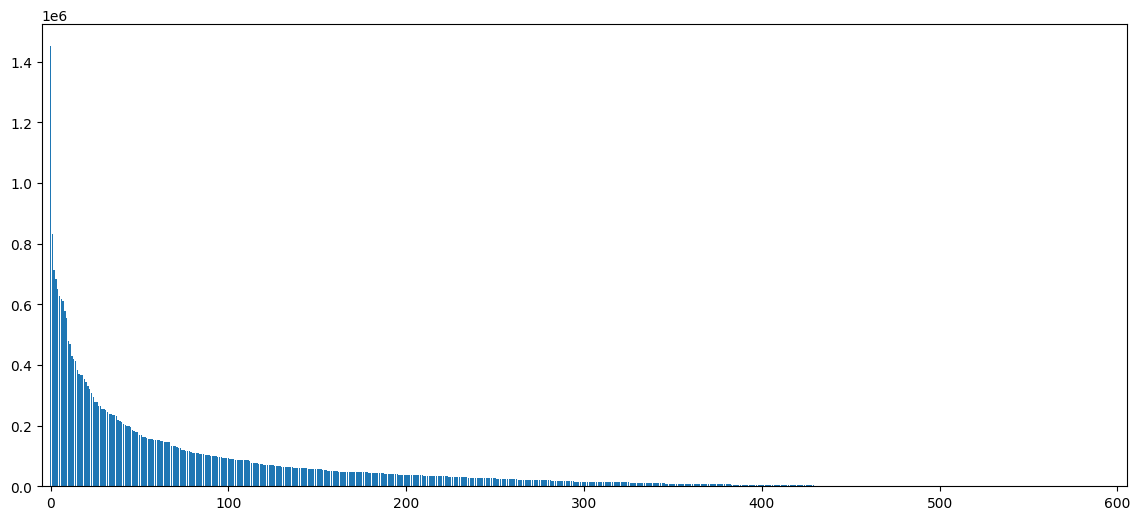

In [ ]:
n = len(sorted_worddict)
plt.figure(figsize=(14,6))
plt.bar(list(range(n)), [i[1] for i in sorted_worddict])
plt.xlim(left=-5)
plt.show()

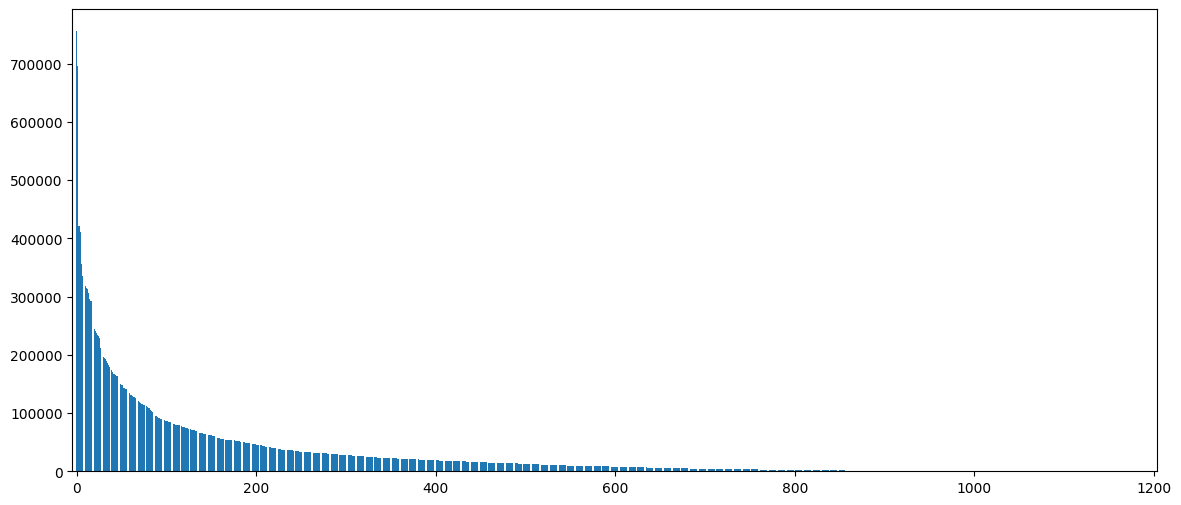

In [ ]:
n = len(sorted_worddict_dir)
plt.figure(figsize=(14,6))
plt.bar(list(range(n)), [i[1] for i in sorted_worddict_dir])
plt.xlim(left=-5)
plt.show()

In [ ]:
print(list(F))
print(list(F['AEC']['NEURALCREST'][0]))

['AEC', 'IC', 'PEC', 'PC']
['EN2-', 'DRGX-', 'LHX2-', 'POU5F1B-', 'POU2F1-', 'POU3F1-']


In [ ]:
# apply cell map to F
cmap = {'MESENCHYMAL': 'OFC', 'NEURALCREST': 'OFC', 'OSTEOCYTE': 'BACKGROUND',
        'HEPATOCYTE': 'BACKGROUND', 'MESOTHELIALEPICARDIUM': 'BACKGROUND', 'NEPHRONPROGENITOR': 'BACKGROUND',
        'PANCREAS': 'BACKGROUND', 'PERIPHERALBLOOD': 'BACKGROUND', 'SPLEEN': 'BACKGROUND', 'STOMACH': 'BACKGROUND'}
# cmap = {k:k for k in set([c for f in F for c in F[f]])}
C = cell_map(F, cmap)
C = {feature: C[feature] for feature in features}  # apply only features that are selected

In [ ]:
print(len(C['AEC']['OFC']))

80207


Hyperparameters

In [ ]:
#embed_dims,num_heads,ff_dims,batches,drops = [4],[2],[16],[128],[0.3]
# embed_dims,num_heads,ff_dims,batches,drops = [2,4,8],[2,4,8],[16,32,64],[32,64,128],[0.4,0.5]
embed_dims,num_heads,ff_dims,batches,drops = [2],[8],[32],[128],[0.4,0.5]
hyper_params = []
for embed_dim in embed_dims:
    for num_head in num_heads:
        for ff_dim in ff_dims:
            for batch in batches:
                for drop in drops:
                    hyper_params += [[embed_dim, num_head, ff_dim, batch, drop, balance_w]]

class_num = len(get_classes(C))
vocab_size = len(sorted(get_vocab(C)))
max_vocab = min(max_vocab, vocab_size)

In [ ]:
print('preprocessing data now...')
train, test, valid, vec = preprocess_data(C, max_vocab=max_vocab, maxlen=maxlen, split=split, balance_w=balance_w)

preprocessing data now...
using data labeling scheme: {'BACKGROUND': 0, 'OFC': 1}
balancing data...
balancing training feature=AEC, cell=BACKGROUND
balancing training feature=AEC, cell=OFC
starting kmer counting...
kmer counting tree completed in 31 sec
starting generative modeling...
generative modeling 161990 sequences in 228 sec
balancing test feature=AEC, cell=BACKGROUND
balancing test feature=AEC, cell=OFC
starting kmer counting...
kmer counting tree completed in 4 sec
starting generative modeling...
generative modeling 46283 sequences in 60 sec


## Training

In [ ]:
from datetime import datetime

cell_idx = get_cell_idx(C)
cell_label_str = '_'.join([k+'-%s'%cell_idx[k] for k in sorted(cell_idx)])
json_score = out_dir+'/%s.%s.%s.score.json'%('_'.join(sorted(features)),cell_label_str,balance_w)

timestamp = datetime.now().strftime("%y%m%d%H%M")
jsonl_timestamp = out_dir+'/timestamp.%s.%s.%s.score.jsonl'%('_'.join(sorted(features)),cell_label_str,balance_w)

if os.path.exists(json_score):
    with open(json_score,'r') as f: score = json.load(f)
else: score = {feature: [hyper_params[0],[], 0.0] for feature in C}

In [ ]:
models = {}
for feature in C:
    for hyper in hyper_params:
        embed_dim, num_head, ff_dim, batch, drop, bl = hyper
        with tf.device('/device:GPU:%s'%gpu_num):
            # -----------------------------------------------------------------------
            inputs = layers.Input(shape=(maxlen,))
            embedding_layer = TokenAndPositionEmbedding(maxlen, max_vocab, embed_dim)
            x = embedding_layer(inputs)
            transformer_block = TransformerBlock(embed_dim, num_head, ff_dim)
            x = transformer_block(x)
            x = layers.GlobalAveragePooling1D()(x)
            x = layers.Dropout(0.2)(x)
            x = layers.Dense(class_num * 64, activation="relu")(x)
            x = layers.Dropout(drop)(x)
            outputs = layers.Dense(class_num, activation="softmax")(x)
            models[feature] = keras.Model(inputs=inputs, outputs=outputs)
            models[feature].compile(optimizer=keras.optimizers.Adam(5e-5),
                                    loss=c2_f1_loss,
                                    metrics=[F1()])
            models[feature].name = feature

            # training-----------------------------------------------------------------------
            callbacks = [
                keras.callbacks.EarlyStopping(monitor="val_f1",
                                                min_delta=1e-2,patience=5,mode='max',verbose=1,
                                                restore_best_weights=True)
            ]
            history = models[feature].fit(
                x=train[feature][0], y=train[feature][1], epochs=epochs,
                validation_data=(test[feature][0],test[feature][1])
            )

            # validation score-----------------------------------------------------------------------
            true = valid[feature][1]
            pred = np.argmax(models[feature].predict(valid[feature][0]), axis=1)
            cm = confusion_matrix(true, pred, c=class_num)
            cm0 = (cm if np.sum(cm) == 0.0 else cm / np.sum(cm))
            print("\nValidation score")
            print(cm)
            print(cm0)
            f1 = f1_score(cm)
            if f1 >= score[feature][-1]:
                print(
                    '-------------------------------new high f1 score: feature=%s, balance=%s, f1=%s -------------------------------\n%s'\
                    %(feature,balance_w,f1,hyper))
                score[feature] = [hyper, [list(l) for l in list(cm)], f1]
                score["timestamp"] = timestamp
                weight_path    = out_dir+'/%s.%s.%s.weights.h5'%(feature,cell_label_str,balance_w)
                # weight_path    = '/'.join(in_path.split('/')[:-1])+'/%s.%s.%s.weights.h5'%(feature,cell_label_str,balance_w)
                if os.path.exists(json_score):
                    with open(json_score,'r') as f:  old_score          = json.load(f)
                    if feature in old_score:         old_score[feature] = score[feature]
                    with open(json_score,'w') as f:
                        json.dump(score,f)
                        models[feature].save_weights(weight_path)
                else:
                    with open(json_score,'w') as f:
                        json.dump(score,f)
                        models[feature].save_weights(weight_path)
                # JSONL format with timestamp
                if os.path.exists(jsonl_timestamp):
                    with open(jsonl_timestamp, 'a') as f:
                        f.write(json.dumps(score) + '\n')
                else:
                    with open(jsonl_timestamp,'w') as f:
                        f.write(json.dumps(score) + '\n')
            else:
                print('f1 score: feature=%s, balance=%s, f1=%s'%(feature,balance_w, f1))
                print("Hyperparameters:", hyper)

            print("\nBaseline")
            print({cell: len(F[feature][cell]) for cell in F[feature]})
            min_score = max([len(F[feature][cell]) for cell in F[feature]]) / sum(
                [len(F[feature][cell]) for cell in F[feature]])
            print(min_score)
            print({cell: len(C[feature][cell]) for cell in C[feature]})
            min_score = max([len(C[feature][cell]) for cell in C[feature]]) / sum(
                [len(C[feature][cell]) for cell in C[feature]])
            print(min_score)
            print("-------------------------------new session-------------------------------")

Epoch 1/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 113s 8ms/step - f1: 0.4969 - loss: 8.2433 - val_f1: 0.3663 - val_loss: 8.2402
Epoch 2/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 122s 7ms/step - f1: 0.5088 - loss: 8.2503 - val_f1: 0.3589 - val_loss: 8.2342
Epoch 3/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - f1: 0.5181 - loss: 8.2356 - val_f1: 0.4241 - val_loss: 8.2037
Epoch 4/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - f1: 0.5406 - loss: 8.1301 - val_f1: 0.5740 - val_loss: 7.8709
Epoch 5/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - f1: 0.5454 - loss: 7.9320 - val_f1: 0.5366 - val_loss: 7.7722
Epoch 6/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - f1: 0.5561 - loss: 7.7217 - val_f1: 0.5595 - val_loss: 7.5014
Epoch 7/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step - f1: 0.5618 - loss: 7.6388 - val_f1: 0.5332 - val_loss: 7.8509
Epoch 8/100
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 157s 8ms/step - f1: 0.5580 - loss: 7.6840 - val_f1: 0.5208 - val_loss: 7.8134
Epoch 9/100
13634

KeyboardInterrupt: 